# Import Libraries

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import urllib

import rioxarray # for the extension to load
import xarray
import rasterio
import geopandas as gpd
#import xrspatial as xrs
from rasterstats import zonal_stats
import rasterstats
import platform
import requests
import sys
import datetime
import os

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import pathlib

import pyproj
from pyproj import Proj
#import simplekml

import netCDF4
import warnings
warnings.simplefilter("ignore") 
#from geocube.api.core import make_geocube

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 11
Python Version 3.13.1 | packaged by conda-forge | (main, Jan 13 2025, 09:37:28) [MSC v.1942 64 bit (AMD64)]
Pandas Version 2.2.3
Numpy Version 2.2.2
Matplotlib Version 3.10.0
py313


# Import Data

In [3]:
#main_path = pathlib.Path("G:/Shared Drives/UGS_Groundwater/Projects/Pahvant_Valley/")
main_path = pathlib.Path(r"G:\Shared Drives\UGS_Flux\Projects_and_Proposals\Castledale_ET")#watersheds_w_valley.shp
#figure_dir = main_path / "Writing" / "Figures" / "GEE_out"
#raw_dir = main_path / "Pahvant_Basins"
#save_place = raw_dir / "GEE_out"
gis_path = main_path / "GIS"
swb_main_path = pathlib.Path(r"C:\Users\paulinkenbrandt\Documents\ArcGIS\Projects\UFN")
swb_coarse_path = swb_main_path / "swb_coarse" / "cottonwood_SWB_100m_v2" / "output_netcdfs"
swb_fine_path = swb_main_path / "SWB" / "output_netcdfs"

In [4]:
#zones_bounds = gpd.read_file(gis_path / 'watersheds_swb.gpkg', driver='GPKG', layer='watersheds_swb')
zones_bounds = gpd.read_file(gis_path / 'watersheds_w_valley.shp')
#zones_wrlu = gpd.read_file(gis_path / "WRLU.shp")

zones_bounds_wgs = zones_bounds.to_crs('epsg:4269')
#zones_wrlu = gpd.read_file(gis_path / 'wrlu_zonal.gpkg', driver='GPKG', layer='wrlu_zonal') 
zones_wrlu = gpd.read_file(gis_path / 'zonal_table.geojson')#"C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/WRLU_for_ET_Est.shp")
zones_wrlu['ID'] = zones_wrlu.index
#zones_wrlu = zones_wrlu.drop(['OBJECTID_1','OBJECTID','State','County','Shape__Are','Shape__Len','Shape_Leng','Shape_Area'],axis=1)
zones_wrlu['Acres'] = zones_wrlu.geometry.area*0.000247105
zones_wrlu_alb = zones_wrlu.to_crs(zones_bounds.crs)

<Axes: >

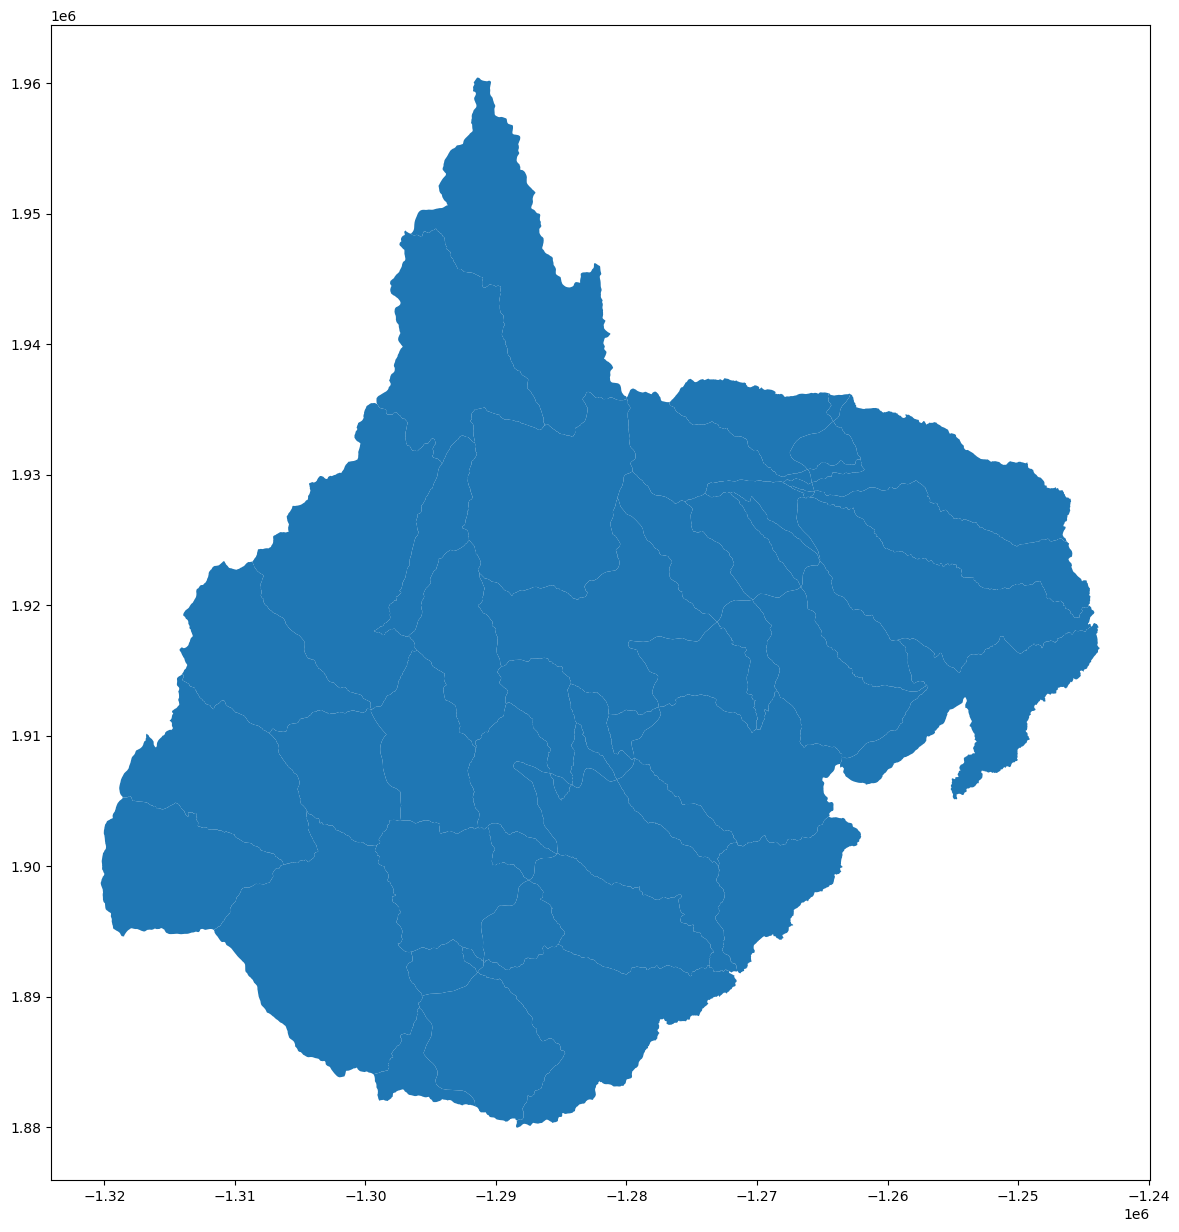

In [5]:
zones_bounds.plot()

# Zonal Statistics by HUC

* https://gis.stackexchange.com/questions/177035/using-geopandas-with-rasterstats-for-zonal-statistic-gives-error
* https://automating-gis-processes.github.io/CSC/notebooks/L5/zonal-statistics.html

## Export Monthly Rasters

In [ ]:

rast = {}

parameters = ['gross_precipitation','actual_et','interception','rainfall','reference_ET0','irrigation','net_infiltration','rejected_net_infiltration','runoff','runon','snowfall','runoff_outside']

for parameter in parameters:              
    dst = f"{parameter}__2020-01-01_to_2024-12-31__600_by_600.nc"
    da = xarray.open_dataset(swb_path / dst, decode_coords="all")
    #water_year = (xds.time.dt.month >= 10) + xds.time.dt.year

    #year_month_idx = pd.MultiIndex.from_arrays([da['time.year'], da['time.month']])
    #da.coords['year_month'] = ('time', year_month_idx)
    da_monthly = da.resample(time='1MS').sum()
    da_monthly = da_monthly.sortby(["time", "x", "y"]) # THIS SOLVED THE PROBLEM
    da_monthly = da_monthly.rio.write_crs("epsg:6350", inplace=True)
    

    #yr_total_bounds = {}
    #yr_total_basin = {}
    
    print(parameter)
    for ind in pd.to_datetime(da_monthly.time.values):
        rasterfile = swb_path / "rasters" / "monthly" / f"{parameter}_{ind:%Y-%m}.tif"
        
        if rasterfile.is_file():
            pass
        else:
            da_monthly[parameter].sel(time = ind).rio.to_raster(rasterfile) #.write_crs("epsg:6350")

## Calculate Monthly Zonal Statistics for HUCs

In [8]:
from geocube.api.core import make_geocube

parameters = ['gross_precipitation',
              'actual_et',
              'interception',
              'rainfall',
              'reference_ET0',
              'irrigation',
              'net_infiltration',
              'rejected_net_infiltration',
              'runoff',
              'runon',
              'snowfall',
              'runoff_outside',
             ]

#wrlu = zones_bounds #[zones_wrlu['SURV_YEAR']=='2021']

zonal_dict = {}

for parameter in parameters:              
    #dst = f"{parameter}__2010-01-01_to_2025-06-01__600_by_600.nc"
    dst = f"{parameter}__2011-01-01_to_2025-05-01__1020_by_960.nc"
    da = xarray.open_dataset(swb_coarse_path / dst, decode_coords="all")

    da_monthly = da.resample(time='MS').sum()
    da_monthly = da_monthly.sortby(["time", "x", "y"]) # THIS SOLVED THE PROBLEM
    da_monthly = da_monthly.rio.write_crs("epsg:6350", inplace=True)
    
    # Create the data mask by rasterizing the unique ID of the vector data
    # ensure the vector data are on the same grid as the stacked raster data
    out_grid = make_geocube(vector_data=zones_bounds, measurements=["UID"], like=da_monthly) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da_monthly[parameter].dims, 
                        da_monthly[parameter].values, 
                        da_monthly[parameter].attrs, 
                        da_monthly[parameter].encoding)
    
    grouped_data = out_grid.groupby(out_grid.UID)
    grid_mean = grouped_data.mean().rename({"vals": f"{parameter}_mean"})
    #grid_std = grouped_data.std().rename({"vals": f"{parameter}_std"})

    #zone_stat = xarray.merge([grid_mean, grid_std]).to_dataframe()
    zone_stat = xarray.merge([grid_mean]).to_dataframe()
    # initializing lists
    test_keys = zone_stat.index.get_level_values(1).unique()
    test_values = pd.to_datetime(da_monthly.time.values)

    # using dictionary comprehension
    # to convert lists to dictionary
    res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

    zn = zone_stat.rename(index=res,level=1)
    zn = zn.drop(['spatial_ref'],axis=1)
    zonal_dict[parameter] = zn

## Merge Watershed Zonal Stats from Coarse SWB with GEE output

In [9]:
zones_bounds = gpd.read_file(gis_path / 'watersheds_w_valley.shp')
zone_data = pd.concat(zonal_dict,axis=1).droplevel(axis=1,level=0)
bounds_zone = zones_bounds.merge(zone_data.reset_index(), on="UID")
for varib in parameters:
    bounds_zone[f'{varib}_acft'] = bounds_zone['acres'] * 0.0833333 * bounds_zone[f'{varib}_mean']
    bounds_zone.drop([f'{varib}_mean'],axis=1,inplace=True)
    #bounds_zone[f'{varib}_std_acft'] = bounds_zone['acres'] * 0.0833333 * bounds_zone[f'{varib}_std']
for col in bounds_zone.columns:
    if "Shape_Le" in col:
        bounds_zone.drop(col,axis=1,inplace=True)

In [10]:
bounds_zone.to_file(gis_path / 'watershed_swb_monthly_coarse.gpkg', driver='GPKG', layer='watershed_swb_monthly_coarse')

## Compare to GEE data

In [7]:
bounds_zone = gpd.read_file(gis_path / 'watershed_swb_monthly_coarse.gpkg', driver='GPKG', layer='watershed_swb_monthly_coarse')
df = pd.read_csv(main_path / "Castledale_SWB" / "Zonal_Water_Volume_AcreFt_1999-01-01_2025-05-01.csv")

df['databand'] = df['dataset'] + "_" +df['band']
df = df.drop(['system:index','.geo','dataset','band'],axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])
df_unstacked = df.set_index(['zonal_id','datetime','databand']).unstack(-1)
df_unstacked.columns = df_unstacked.columns.droplevel(level=0)

#drop_fields = ['huc_8','huc_12','acres','hu_10_name','hu_12_name','Shape_Area','Elev_area','geometry']

merged = pd.merge(bounds_zone.rename(columns={'time':'datetime','UID':'zonal_id'}).set_index(['zonal_id','datetime']),
                  df_unstacked,left_index=True,right_index=True)

In [13]:
merged.to_parquet(gis_path / 'watershed_swb_gee_monthly_coarse.parquet')
merged.to_file(gis_path / 'watershed_swb_gee_monthly_coarse.gpkg', driver='GPKG', layer='watershed_swb_gee_monthly_coarse')

In [8]:
et_fields = ['Elev_area','OpenET_sims_et','OpenET_GEESEBAL_et', 'OpenET_disalexi_et', 'OpenET_eemetric_et',
       'OpenET_ens_et_ensemble_mad', 'OpenET_ptjpl_et', 
       'OpenET_ssebop_et','TerraClimate_aet','actual_et_acft']
merged_et = merged[et_fields]

merged_ppt = merged[['Elev_area','gross_precipitation_acft','PRISM_ppt','TerraClimate_pr',]]

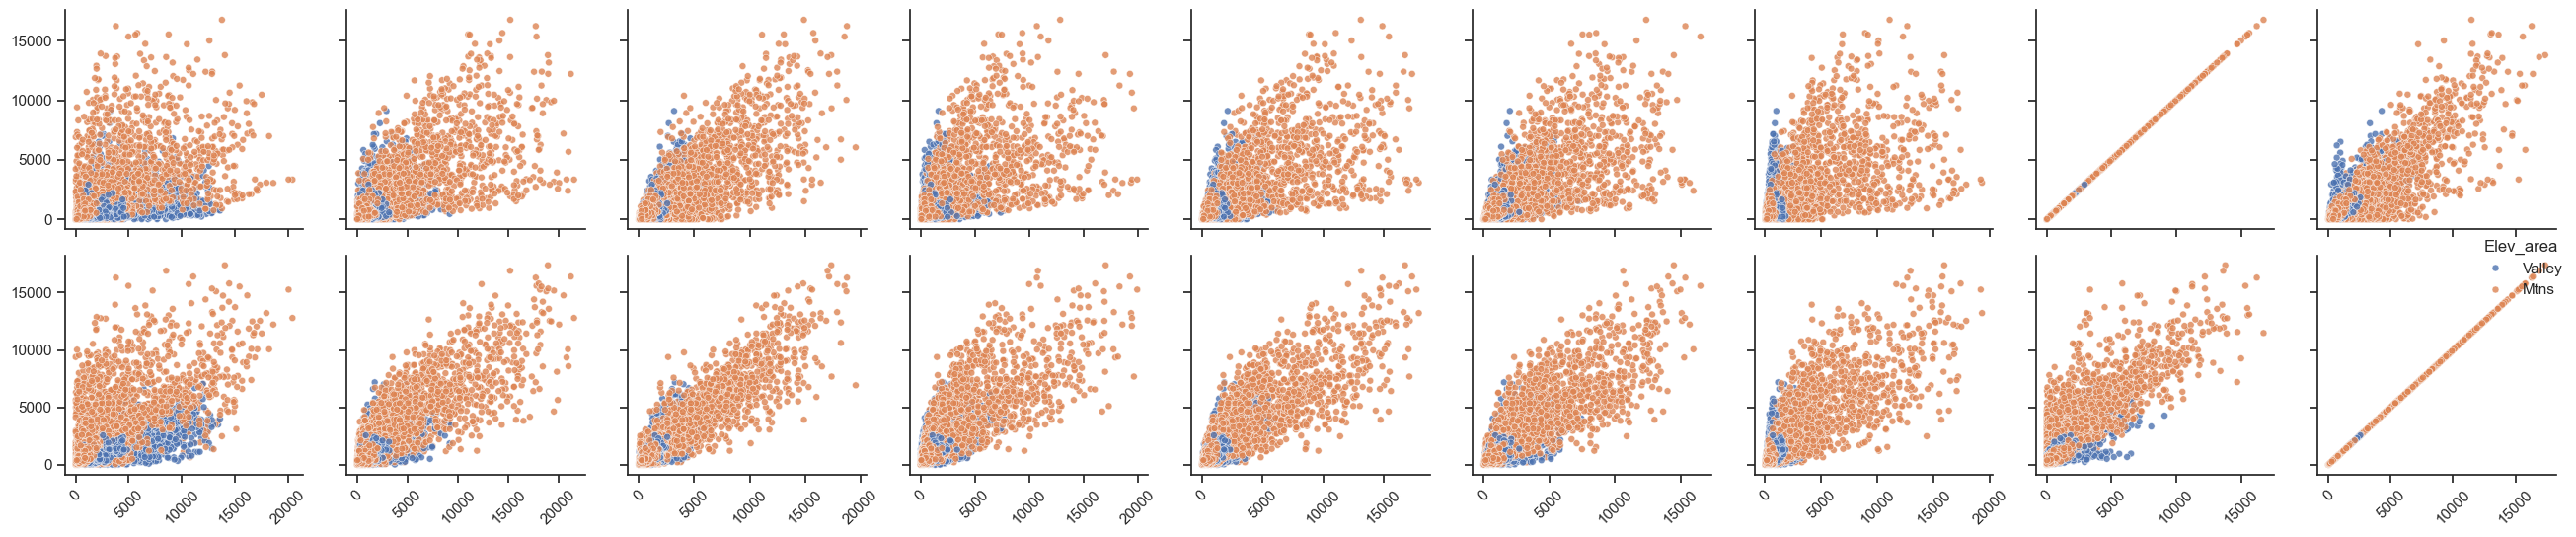

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

# Put your variables in the order they appeared across the columns
x_vars = [
    'OpenET_sims_et','OpenET_GEESEBAL_et', 'OpenET_disalexi_et', 'OpenET_eemetric_et',
       'OpenET_ens_et_ensemble_mad', 'OpenET_ptjpl_et', 
       'OpenET_ssebop_et','TerraClimate_aet','actual_et_acft'
]

# 👉 the two variables that were in the bottom rows
y_vars = ["TerraClimate_aet", "actual_et_acft"]

g = sns.PairGrid(
        data=merged_et,
        x_vars=x_vars,          # every column along x
        y_vars=y_vars,          # only the last two along y
        hue="Elev_area",         # or whatever column you used
        height=2.8,             # size of each panel
        aspect=1                # keep them square
)

g.map(sns.scatterplot, s=25, alpha=.8)
g.add_legend()
g.set(xlabel="", ylabel="")          # optional: tidy labels
for ax in g.axes.flat:               # rotate x‑ticks for readability
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

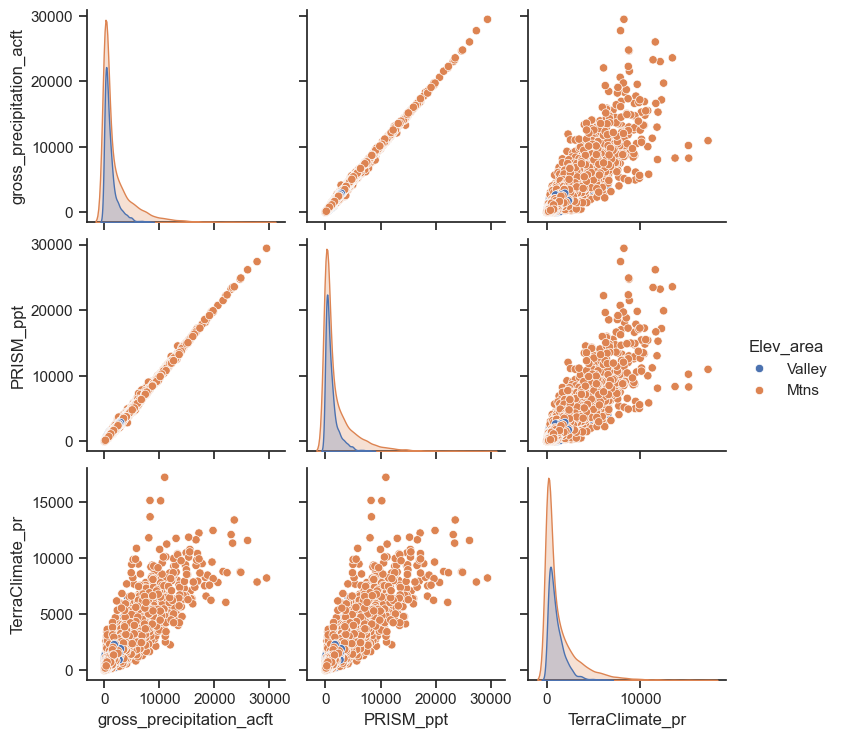

In [16]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(merged_ppt, hue='Elev_area')

<Axes: >

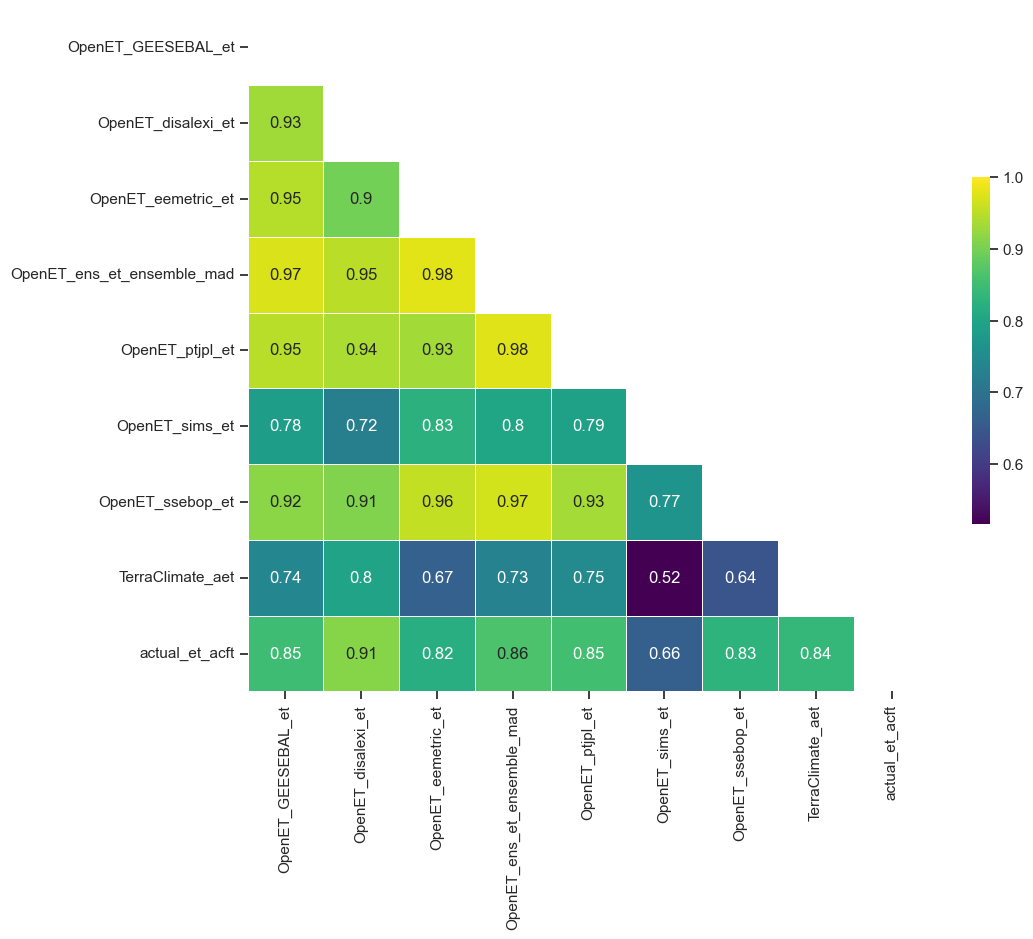

In [17]:
#swb_path = main_path / "SWB"
d = merged_et[[ 'OpenET_GEESEBAL_et', 'OpenET_disalexi_et',
       'OpenET_eemetric_et', 'OpenET_ens_et_ensemble_mad', 'OpenET_ptjpl_et',
       'OpenET_sims_et', 'OpenET_ssebop_et', 'TerraClimate_aet',
       'actual_et_acft']]
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='viridis', vmax=1, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
merged['huc_elev'] = merged['hu_10_name'] + "\n" + merged['Elev_area']
major_grps = merged.groupby(['huc_elev','datetime']).sum(numeric_only=True)
huc_grp = merged.groupby(['hu_10_name','Elev_area','datetime']).sum(numeric_only=True)
huc_grp_wy = merged.groupby(['hu_10_name','Elev_area',pd.Grouper(level='datetime', freq='A-SEP')]).sum(numeric_only=True)
huc_grp_wy = huc_grp_wy[(huc_grp_wy.index.get_level_values(-1) < pd.to_datetime('2025-09-01'))&(huc_grp_wy.index.get_level_values(-1) > pd.to_datetime('2010-10-01'))]
huc_grp_wy["huc_elev"] = huc_grp_wy.index.get_level_values(0) +" - " + huc_grp_wy.index.get_level_values(1) 
huc_grp["huc_elev"] = huc_grp.index.get_level_values(0) +"\n" + huc_grp.index.get_level_values(1) 

#sns.pairplot(huc_grp_wy[et_fields[1:]+["huc_elev"]],hue="huc_elev")

In [20]:
model_names = {'OpenET_disalexi_et': 'OpenET DisALEXI', 
               'OpenET_eemetric_et': 'OpenET eeMETRIC',
               'OpenET_ens_et_ensemble_mad': 'OpenET Ensemble', 
               'OpenET_ptjpl_et': 'OpenET PT-JPL',
               'OpenET_ssebop_et': 'OpenET SSEBop',
               'TerraClimate_aet': 'TerraClimate'}

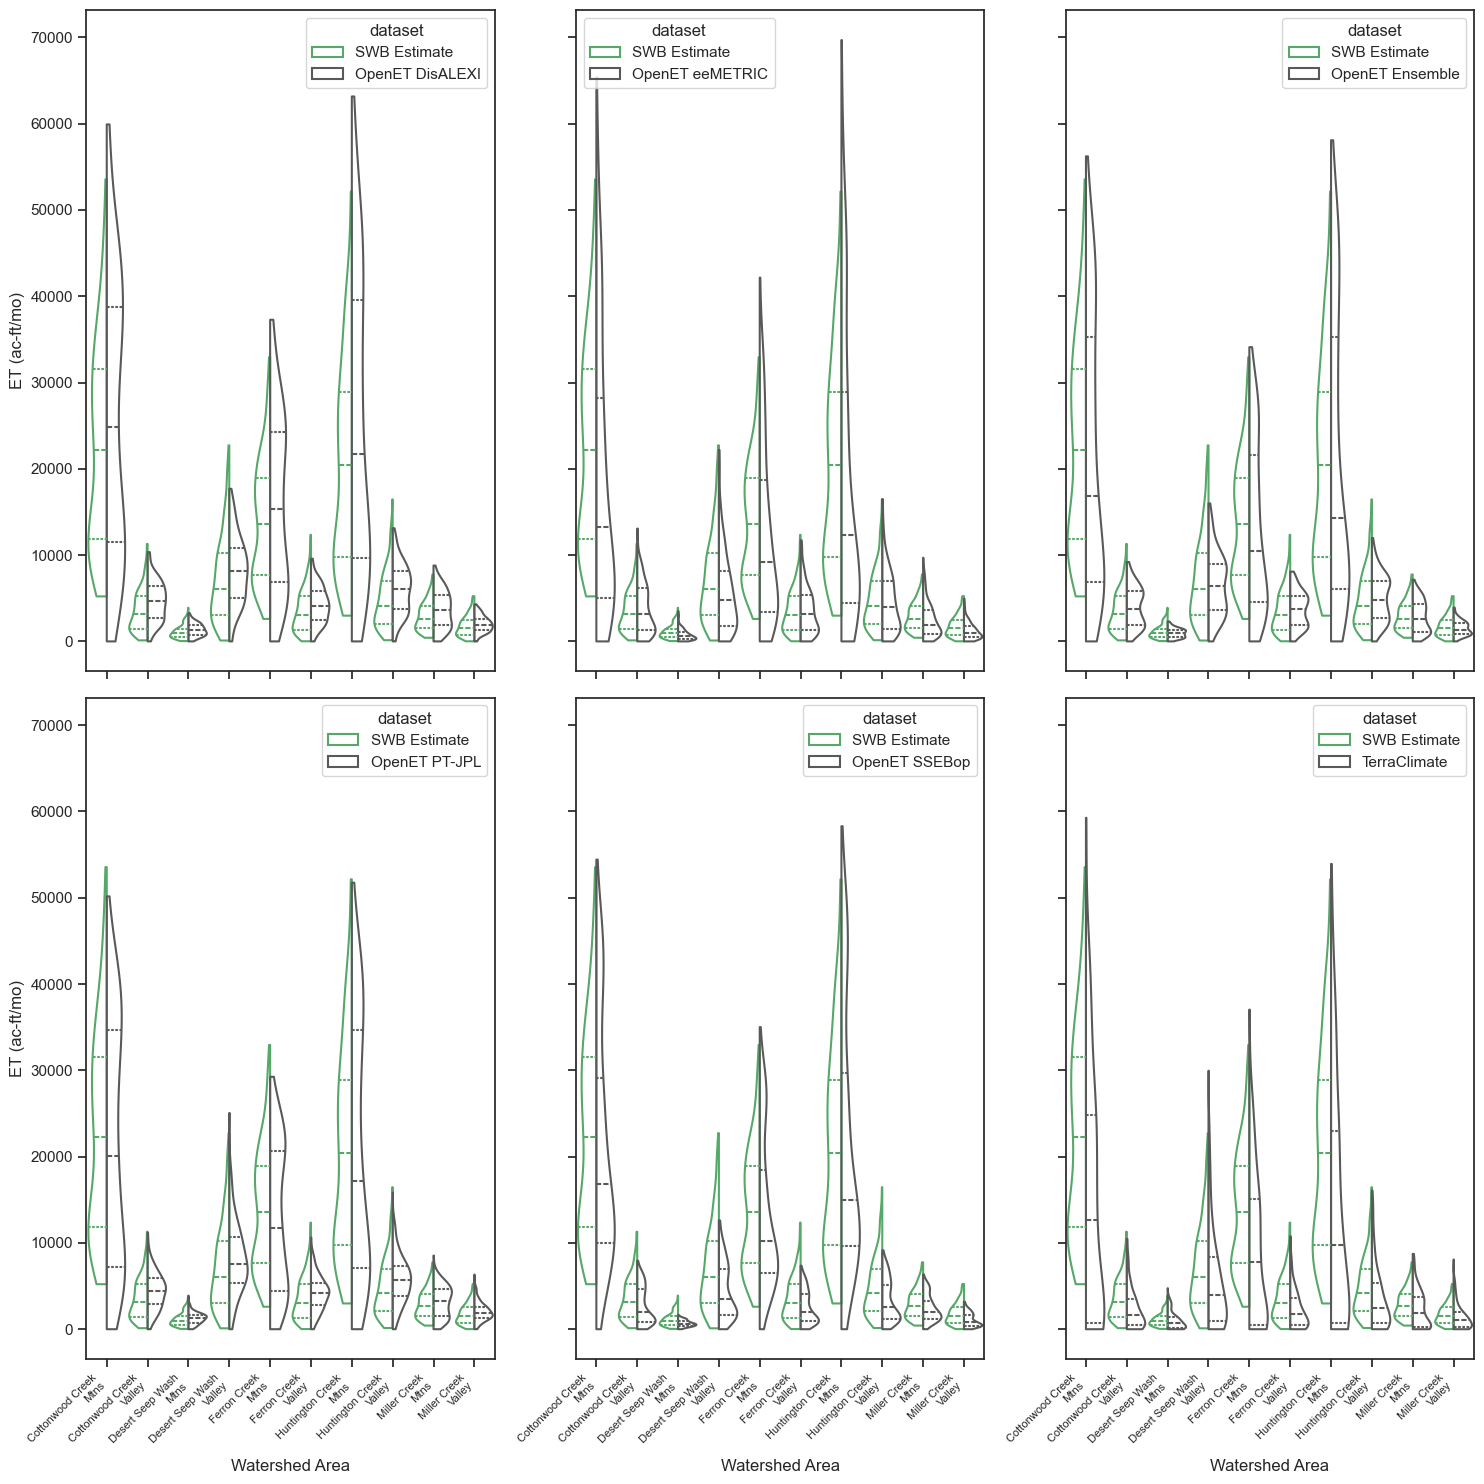

In [22]:
fig, ax = plt.subplots(2, 3, sharex=True,sharey=True)
i = 0
j = 0
cnt = 0
for key,value in model_names.items():
    
    if cnt > 2:
        i = 1
        j = cnt - 3
    else:
        i = 0
        j = cnt
    cnt += 1
    
    vio = major_grps[["actual_et_acft",
                      key,
                     ]].rename(columns={"actual_et_acft":"SWB Estimate",
                               key:value}).stack().to_frame().reset_index().rename(columns={0:'ET (ac-ft/mo)','level_2':'dataset'})
    #vio['colors'] = vio['dataset'].replace(
    # Draw a nested violinplot and split the violins for easier comparison
    sns.violinplot(data=vio, 
                   x="huc_elev", 
                   y='ET (ac-ft/mo)', 
                   hue="dataset", 
                   width=0.9,
                   split=True, 
                   inner="quart", 
                   fill=False, 
                   cut=0, 
                   density_norm='width',
                   palette={"SWB Estimate": "g", value: ".35"},
                   ax = ax[i,j],
                  )
# rotate tick labels 45° and reduce font size
ax[1,0].set_xticklabels(ax[i,j].get_xticklabels(),
                   rotation=45,            # angle
                   ha='right',             # align so they don’t overlap
                   fontsize=8)             # smaller font
# rotate tick labels 45° and reduce font size
ax[1,1].set_xticklabels(ax[i,j].get_xticklabels(),
                   rotation=45,            # angle
                   ha='right',             # align so they don’t overlap
                   fontsize=8)             # smaller font
# rotate tick labels 45° and reduce font size
ax[1,2].set_xticklabels(ax[i,j].get_xticklabels(),
                   rotation=45,            # angle
                   ha='right',             # align so they don’t overlap
                   fontsize=8)             # smaller font
ax[1,0].set_xlabel("Watershed Area")
ax[1,1].set_xlabel("Watershed Area")
ax[1,2].set_xlabel("Watershed Area")
fig.tight_layout()
#plt.savefig("")

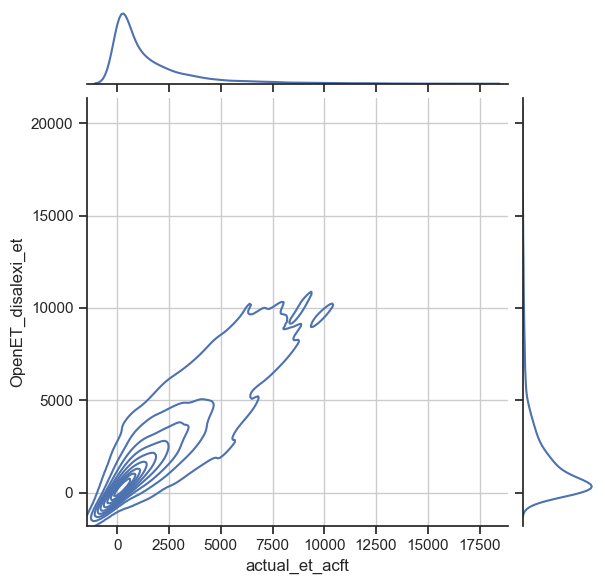

In [24]:
import seaborn as sns

# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=merged,
    x="actual_et_acft", 
    y="OpenET_disalexi_et", 
    #hue="huc_elev",
    kind="kde",
)
plt.grid()

In [16]:
for ind in merged.index.get_level_values(0).unique():
    merged.loc[ind]

Index([12, 13, 15, 16, 17, 18, 19, 20, 35, 36, 37, 38, 39, 40, 41], dtype='int64', name='zonal_id')

In [13]:
bounds_zone.to_file(gis_path / 'watershed_swb_monthly.gpkg', driver='GPKG', layer='watershed_swb_monthly')


# Zonal Statistics by WRLU

## Calculate Monthly Zonal Statistics for Fields

In [19]:
from geocube.api.core import make_geocube

parameters = ['gross_precipitation',
              'actual_et',
              'interception',
              'rainfall',
              'reference_ET0',
              'irrigation',
              'net_infiltration',
              'rejected_net_infiltration',
              'runoff',
              'runon',
              'snowfall',
              'runoff_outside',
             ]

#wrlu = zones_bounds #[zones_wrlu['SURV_YEAR']=='2021']

zonal_dict = {}

for parameter in parameters:              
    #dst = f"{parameter}__2010-01-01_to_2025-06-01__600_by_600.nc"
    dst = f"{parameter}__2010-01-01_to_2025-06-01__600_by_600.nc"
    da = xarray.open_dataset(swb_fine_path / dst, decode_coords="all")

    da_monthly = da.resample(time='MS').sum()
    da_monthly = da_monthly.sortby(["time", "x", "y"]) # THIS SOLVED THE PROBLEM
    da_monthly = da_monthly.rio.write_crs("epsg:6350", inplace=True)
    
    # Create the data mask by rasterizing the unique ID of the vector data
    # ensure the vector data are on the same grid as the stacked raster data
    out_grid = make_geocube(vector_data=zones_wrlu_alb, measurements=['ID'], like=da_monthly) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da_monthly[parameter].dims, 
                        da_monthly[parameter].values, 
                        da_monthly[parameter].attrs, 
                        da_monthly[parameter].encoding)
    
    grouped_data = out_grid.groupby(out_grid.ID)
    grid_mean = grouped_data.mean().rename({"vals": f"{parameter}_mean"})
    #grid_std = grouped_data.std().rename({"vals": f"{parameter}_std"})

    #zone_stat = xarray.merge([grid_mean, grid_std]).to_dataframe()
    zone_stat = xarray.merge([grid_mean]).to_dataframe()
    # initializing lists
    test_keys = zone_stat.index.get_level_values(1).unique()
    test_values = pd.to_datetime(da_monthly.time.values)

    # using dictionary comprehension
    # to convert lists to dictionary
    res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

    zn = zone_stat.rename(index=res, level=1)
    zn = zn.drop(['spatial_ref'], axis=1)
    zonal_dict[parameter] = zn

In [7]:
from geocube.api.core import make_geocube

parameters = ['gross_precipitation',
              'actual_et',
              'interception',
              'rainfall',
              'reference_ET0',
              'irrigation',
              'net_infiltration',
              'rejected_net_infiltration',
              'runoff',
              'runon',
              'snowfall',
              'runoff_outside',
             ]

#wrlu = zones_bounds #[zones_wrlu['SURV_YEAR']=='2021']

zonal_dict = {}

for parameter in parameters:              
    #dst = f"{parameter}__2010-01-01_to_2025-06-01__600_by_600.nc"
    dst = f"{parameter}__2010-01-01_to_2025-06-01__600_by_600.nc"
    da = xarray.open_dataset(swb_fine_path / dst, decode_coords="all")

    da = da.sortby(["time", "x", "y"]) # THIS SOLVED THE PROBLEM
    da = da.rio.write_crs("epsg:6350", inplace=True)
    
    # Create the data mask by rasterizing the unique ID of the vector data
    # ensure the vector data are on the same grid as the stacked raster data
    out_grid = make_geocube(vector_data=zones_wrlu_alb, measurements=['ID'], like=da) 

    # Perform Zonal Statistics (Mean and Std Dev); This will result in a multi-index df with LUID and year
    out_grid["vals"] = (da[parameter].dims, 
                        da[parameter].values, 
                        da[parameter].attrs, 
                        da[parameter].encoding)
    
    grouped_data = out_grid.groupby(out_grid.ID)
    grid_mean = grouped_data.mean().rename({"vals": f"{parameter}_mean"})
    #grid_std = grouped_data.std().rename({"vals": f"{parameter}_std"})

    #zone_stat = xarray.merge([grid_mean, grid_std]).to_dataframe()
    zone_stat = xarray.merge([grid_mean]).to_dataframe()
    # initializing lists
    test_keys = zone_stat.index.get_level_values(1).unique()
    test_values = pd.to_datetime(da.time.values)

    # using dictionary comprehension
    # to convert lists to dictionary
    res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

    zn = zone_stat.rename(index=res, level=1)
    zn = zn.drop(['spatial_ref'], axis=1)
    zonal_dict[parameter] = zn

In [12]:
dly_zonal = pd.concat(zonal_dict,axis=1).droplevel(axis=1,level=0)
dly_zonal.to_parquet(gis_path / 'wrlu_swb_daily_data.parquet')

In [32]:
zones_wrlu = gpd.read_file(gis_path / 'zonal_table.geojson')#"C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/WRLU_for_ET_Est.shp")
zones_wrlu['ID'] = zones_wrlu.index
#zones_wrlu = zones_wrlu.drop(['OBJECTID_1','OBJECTID','State','County','Shape__Are','Shape__Len','Shape_Leng','Shape_Area'],axis=1)

zones_wrlu_alb = zones_wrlu.to_crs(zones_bounds.crs)
zones_wrlu_alb['Acres'] = zones_wrlu_alb.geometry.area*0.000247105
zones_wrlu_alb

,id,Acreage,Croptype,Depletion,Diversion,ID,Meternumbe,Shape_Area,Shape_Leng,zonal_id,geometry,Acres
0,00000000000000000000,46.779480,Alfalfa,,,0,CW40,315755.989896,2600.763918,0.0,"POLYGON ((-1282823.384 1900420.678, -1282851.4...",46.805121
1,00000000000000000001,29.616903,Alfalfa,,,1,CW27,199936.937966,1794.516594,1.0,"POLYGON ((-1281868.468 1900904.169, -1281868.0...",29.619494
2,00000000000000000002,48.352931,Alfalfa,,,2,CW61,326185.208825,2454.469306,2.0,"POLYGON ((-1282324.213 1898229, -1282370.531 1...",48.345917
3,00000000000000000003,35.123619,Alfalfa,,,3,CW53,236899.196342,2129.973403,3.0,"POLYGON ((-1283698.485 1897350.573, -1283707.1...",35.129523
4,00000000000000000004,34.864141,Alfalfa,,,4,CW52,235161.443135,2714.302002,4.0,"POLYGON ((-1283698.485 1897350.573, -1283640.1...",34.870071
...,...,...,...,...,...,...,...,...,...,...,...,...
231,000000000000000000e7,0.000000,,,,231,CW21,153791.204724,2001.003010,231.0,"POLYGON ((-1283319.035 1901053.97, -1283299.37...",22.778493
232,000000000000000000e8,0.000000,,,,232,CW21,64647.921508,1155.803729,232.0,"POLYGON ((-1283544.101 1900970.356, -1283555.6...",9.576404
233,000000000000000000e9,0.000000,,,,233,CW21,26820.774829,905.633405,233.0,"POLYGON ((-1283858.927 1900866.589, -1283858.3...",3.976343
234,000000000000000000ea,0.000000,,,,234,CW21,36798.447971,753.258258,234.0,"POLYGON ((-1283585.508 1901718.846, -1283596.1...",5.450943


In [33]:

zone_wrlu_data = pd.concat(zonal_dict,axis=1).droplevel(axis=1,level=0)
zones_wrlu_alb =zones_wrlu_alb.drop(columns = ['id'], axis = 1)
wrlu_zone = zones_wrlu_alb.reset_index().merge(zone_wrlu_data.reset_index(), on="ID")
for varib in parameters:
    wrlu_zone[f'{varib}_acft'] = wrlu_zone['Acres'] * 0.0833333 * wrlu_zone[f'{varib}_mean']
    wrlu_zone.drop([f'{varib}_mean'],axis=1,inplace=True)
    #bounds_zone[f'{varib}_std_acft'] = bounds_zone['acres'] * 0.0833333 * bounds_zone[f'{varib}_std']
for col in wrlu_zone.columns:
    if "Shape_Le" in col:
        wrlu_zone.drop(col,axis=1,inplace=True)
#wrlu_zone = wrlu_zone.drop(columns=['acres'],axis=1)
zone_wrlu_data.to_parquet(gis_path / 'wrlu_swb_monthly_data.parquet')
#

In [34]:
wrlu_zone.to_file(gis_path / 'wrlu_swb_monthly_fine.gpkg', driver='GPKG', layer='wrlu_swb_monthly_fine')

## Merge WRLU Zonal Stats from fine SWB with output from GEE

In [56]:
zone_wrlu_data = pd.read_parquet(gis_path / 'wrlu_swb_monthly_data.parquet')
wrlu_zone = gpd.read_file(gis_path / 'wrlu_swb_monthly_fine.gpkg', driver='GPKG', layer='wrlu_swb_monthly_fine')
wrlu_zone['datetime'] = pd.to_datetime(wrlu_zone['time'])
wrlu_zone['zonal_id'] = wrlu_zone['ID'].astype(int)

df = pd.read_csv(main_path / "Castledale_SWB" / "WRLU_Zonal_Water_Volume_AcreFt_1999-01-01_2025-05-01.csv")
df['databand'] = df['dataset'] + "_" +df['band']
df = df.drop(['system:index','.geo','dataset','band'],axis=1)
df['datetime'] = pd.to_datetime(df['datetime'])
df_unstacked = df.set_index(['zonal_id','datetime','databand']).unstack(-1)
df_unstacked.columns = df_unstacked.columns.droplevel(level=0)
df_unstacked.index = df_unstacked.index.set_levels([df_unstacked.index.levels[0].astype(int), df_unstacked.index.levels[1]])
merged = pd.merge(wrlu_zone.set_index(['zonal_id','datetime']),
                  df_unstacked,left_index=True,right_index=True)

In [57]:
merged.to_parquet(gis_path / 'wrlu_swb_gee_monthly_fine.parquet')
merged.to_file(gis_path / 'wrlu_swb_gee_monthly_fine.gpkg', driver='GPKG', layer='wrlu_swb_gee_monthly_fine')

In [ ]:
WRLU_Zonal_Water_Volume_AcreFt_1999-01-01_2025-05-01

In [ ]:
wrlu_zone['year'] = wrlu_zone['time'].dt.year
wrlu_zone['irr_season'] = wrlu_zone['time'].dt.month.isin([4,5,6,7,8,9,10])

In [ ]:
wrlu_zone_x = wrlu_zone[wrlu_zone['year']>2015]
mean_swb = wrlu_zone_x.groupby(['luid','year']).sum().groupby(level=0).mean()

In [ ]:
mean_swb['gross_precipitation_mean']

In [ ]:
pd.merge(wrlu,mean_swb,on='luid').plot(column='gross_precipitation_mean', legend=True)

In [ ]:
# initializing lists
test_keys = zone_stat.index.get_level_values(1).unique()
test_values = pd.to_datetime(da_monthly.time.values)
 
# using dictionary comprehension
# to convert lists to dictionary
res = {test_keys[i]: test_values[i] for i in range(len(test_keys))}

zn = zone_stat.rename(index=res,level=1)
zn = zn.drop(['spatial_ref'],axis=1)
zn

In [ ]:
zn = zone_stat.rename(index={0:2016,1:2017,2:2018,3:2019,4:2020,5:2021,6:2022},level=1)
zn = zn.drop(['spatial_ref'],axis=1)
    
zn

## By Calendar Year

In [ ]:
rast = {}


dfs_bounds = {}
dfs_basin = {}

parameters = ['gross_precipitation','actual_et','interception','rainfall','reference_ET0','irrigation','net_infiltration','rejected_net_infiltration','runoff','runon','snowfall','runoff_outside']

for parameter in parameters:              
    dst = f"{parameter}__2001-01-01_to_2022-12-31__900_by_800.nc"
    xds = xarray.open_dataset(swb_path / dst, decode_coords="all")
    #water_year = (xds.time.dt.month >= 10) + xds.time.dt.year
    xds.coords['year'] = xds.time.dt.year
    xds = xds.groupby('year', restore_coord_dims=True).sum(dim='time')
    xds = xds.sortby(["year", "x", "y"]) # THIS SOLVED THE PROBLEM
    xds = xds.rio.write_crs("epsg:6350", inplace=True)
    #xds_wy.to_netcdf(swb_path / "netcdf_out" / f"{parameter}_wy_2016-01-01_to_2021-12-31__690_by_612.nc")

    #yr_total_bounds = {}
    #yr_total_basin = {}
    
    print(parameter)
    for wy in range(2001,2023):
        rasterfile = swb_path / "rasters" / "cy" / f"{parameter}_{wy}.tif"
        
        if rasterfile.is_file():
            pass
        else:
            xds[parameter].sel(year = wy).rio.to_raster(rasterfile) #.write_crs("epsg:6350")

## By Water Year

In [ ]:
rast = {}


dfs_bounds = {}
dfs_basin = {}

parameters = ['gross_precipitation','actual_et','interception','rainfall','reference_ET0','irrigation','net_infiltration','rejected_net_infiltration','runoff','runon','snowfall','runoff_outside']

for parameter in parameters:              
    dst = f"{parameter}__2001-01-01_to_2022-12-31__900_by_800.nc"
    xds = xarray.open_dataset(swb_path / dst, decode_coords="all")
    water_year = (xds.time.dt.month >= 10) + xds.time.dt.year
    xds.coords['water_year'] = water_year
    xds_wy = xds.groupby('water_year', restore_coord_dims=True).sum(dim='time')

    xds_wy.to_netcdf(swb_path / "netcdf_out" / f"{parameter}_wy_2001-01-01_to_2022-12-31__690_by_612.nc")

    yr_total_bounds = {}
    yr_total_basin = {}
    
    print(parameter)
    for wy in range(2001,2023):
        print(wy)
        rasterfile = swb_path / "rasters" / f"{parameter}_{wy}.tif"
        path = Path(rasterfile)
        if path.is_file():
            pass
        else:
            xds_wy[parameter].sel(water_year = wy).rio.to_raster(rasterfile) #.write_crs("epsg:6350")
        rast[f"{parameter}{wy}"] = rasterio.open(rasterfile)
        # Read the raster values
        array = rast[f"{parameter}{wy}"].read(1)

        # Get the affine
        affine = rast[f"{parameter}{wy}"].transform

        rast[f"{parameter}{wy}"].close()

        zs_bounds = zonal_stats(zones_bounds, array, affine=affine, stats=['mean'], nodata=-999) #['mean', 'median', 'majority']
        zs_basin = zonal_stats(zones_wrlu, array, affine=affine, stats=['mean'], nodata=-999) #['mean', 'median', 'majority']

        
        total_bounds = {}
        for i in range(len(zones_bounds.geometry.area)):
            area_bounds = zones_bounds.geometry.area[i]
            p_meas_bounds = zs_bounds[i]['mean']*0.0254 # in to meters
            #total_bounds[zones_bounds.loc[i,'hu_12_name']] = area_bounds*p_meas_bounds*0.000810714
            total_bounds[zones_bounds.loc[i,'ID']] = area_bounds*p_meas_bounds*0.000810714
        #area
        
        total_basin = {}
        for i in range(len(zones_wrlu.geometry.area)):
            area_basin = zones_wrlu.geometry.area[i]
            if zs_basin[i]['mean'] is None:
                p_meas_basin = 0
            else:
                p_meas_basin = zs_basin[i]['mean']*0.0254 # in to meters
            total_basin[zones_wrlu.loc[i,'luid']] = area_basin*p_meas_basin*0.000810714

            
        yr_total_bounds[wy] = total_bounds
        yr_total_basin[wy] = total_basin

    dfs_bounds[f"{parameter}"] = pd.DataFrame(yr_total_bounds)
    dfs_basin[f"{parameter}"] = pd.DataFrame(yr_total_basin)
    


In [ ]:
wy_bounds = pd.concat(dfs_bounds)#.to_clipboard()

In [ ]:
pd.concat(dfs_basin).to_clipboard()

In [ ]:
wy_bounds.index.get_level_values(0).unique()

In [ ]:
wy_bounds.loc['runoff'].loc[[7,14,57,26,33,3]].T.sum(axis=1)[1:].plot()

In [ ]:
wy_bounds.loc['net_infiltration'].loc[[7,14,57,26,33,3]].T.sum(axis=1)[1:]#.plot()